# Linear Regression 6133 Тюгаев Никита Павлович

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
from copy import deepcopy


pd.set_option("display.float_format", lambda x: "%.3f" % x)

import warnings

warnings.filterwarnings("ignore")

#### 1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [2]:
automobile = fetch_ucirepo(id=10)

df = (
    pd.concat([automobile.data.features, automobile.data.targets], axis=1)
    .replace("?", np.nan)
    .dropna(subset=["price"])
)

variable_info = automobile.variables.drop(
    columns=["role", "demographic", "units", "missing_values"]
)

#### 2. Датасет и подготовка данных, этап 1:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Нормализовать численные данные.
   - Визуализировать `heatmap`-матрицу кореллированности признаков.
   - Визуализировать взаимосвязь между `target`-переменной и каждым из признаком (с использованием `srs.pairplot` или `pandas.plotting.scatter_matrix`). Лучше всего построить диаграмму попарного распределения между таргетом и каждым из признаков отдельно (пример с `sns.FacetGrid` в лекции).
   - Разбить выборку на обучающую и тестовую.
     > Из датафреймов обучающей и тестовой выборки необходимо временно убрать категориальные признаки (исходные датафреймы сохранить для 2 этапа).

##### Привести описание датасета.

**Датасет UCI ML Automobile содержит информацию об автомобилях и их атрибутах, включающими как категориальные признаки (марка, тип топлива, тип кузова), так и числовые характеристики (мощность двигателя, расход топлива, габариты). При использовании цены (price) в качестве целевой переменной задача сводится к регрессии, где требуется предсказать стоимость автомобиля на основе его технических характеристик и других параметров.**

In [3]:
display(variable_info)

,name,type,description
0,price,Continuous,continuous from 5118 to 45400
1,highway-mpg,Continuous,continuous from 16 to 54
2,city-mpg,Continuous,continuous from 13 to 49
3,peak-rpm,Continuous,continuous from 4150 to 6600
4,horsepower,Continuous,continuous from 48 to 288
5,compression-ratio,Continuous,continuous from 7 to 23
6,stroke,Continuous,continuous from 2.07 to 4.17
7,bore,Continuous,continuous from 2.54 to 3.94
8,fuel-system,Categorical,"1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi"
9,engine-size,Continuous,continuous from 61 to 326


##### Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".

In [4]:
print("Количество пропущенных значений в каждом столбце:")
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце:


price                 0
highway-mpg           0
city-mpg              0
peak-rpm              2
horsepower            2
compression-ratio     0
stroke                4
bore                  4
fuel-system           0
engine-size           0
num-of-cylinders      0
engine-type           0
curb-weight           0
height                0
width                 0
length                0
wheel-base            0
engine-location       0
drive-wheels          0
body-style            0
num-of-doors          2
aspiration            0
fuel-type             0
make                  0
normalized-losses    37
symboling             0
dtype: int64

In [5]:
categorical_cols = variable_info[
    variable_info["type"].isin(["Integer", "Categorical", "Binary"])
]["name"].to_list()
numerical_cols = (
    variable_info[variable_info["type"].isin(["Continuous"])].loc[1:, "name"].to_list()
)

for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print(
    "Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:"
)
display(df.isnull().sum())

Количество пропущенных значений в каждом столбце после заполнения пропущенных значений:


price                0
highway-mpg          0
city-mpg             0
peak-rpm             0
horsepower           0
compression-ratio    0
stroke               0
bore                 0
fuel-system          0
engine-size          0
num-of-cylinders     0
engine-type          0
curb-weight          0
height               0
width                0
length               0
wheel-base           0
engine-location      0
drive-wheels         0
body-style           0
num-of-doors         0
aspiration           0
fuel-type            0
make                 0
normalized-losses    0
symboling            0
dtype: int64

##### Визуализировать `heatmap`-матрицу кореллированности признаков.

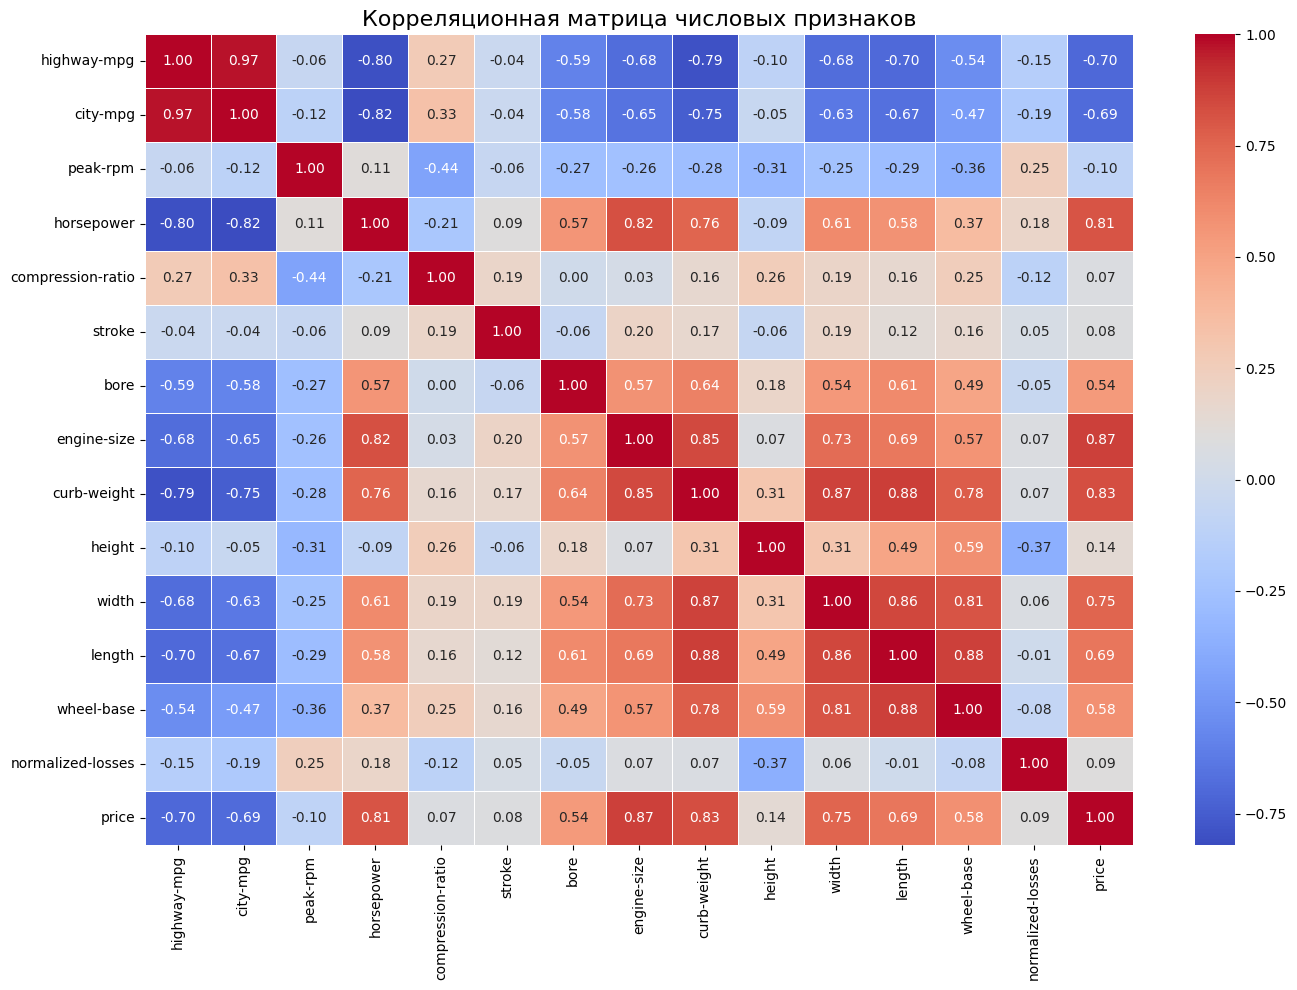

In [6]:
correlation_matrix = df[numerical_cols + ["price"]].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица числовых признаков", fontsize=16)
plt.tight_layout()
plt.show()

##### Визуализировать взаимосвязь между `target`-переменной и каждым из признаком (с использованием `srs.pairplot` или `pandas.plotting.scatter_matrix`). Лучше всего построить диаграмму попарного распределения между таргетом и каждым из признаков отдельно (пример с `sns.FacetGrid` в лекции).

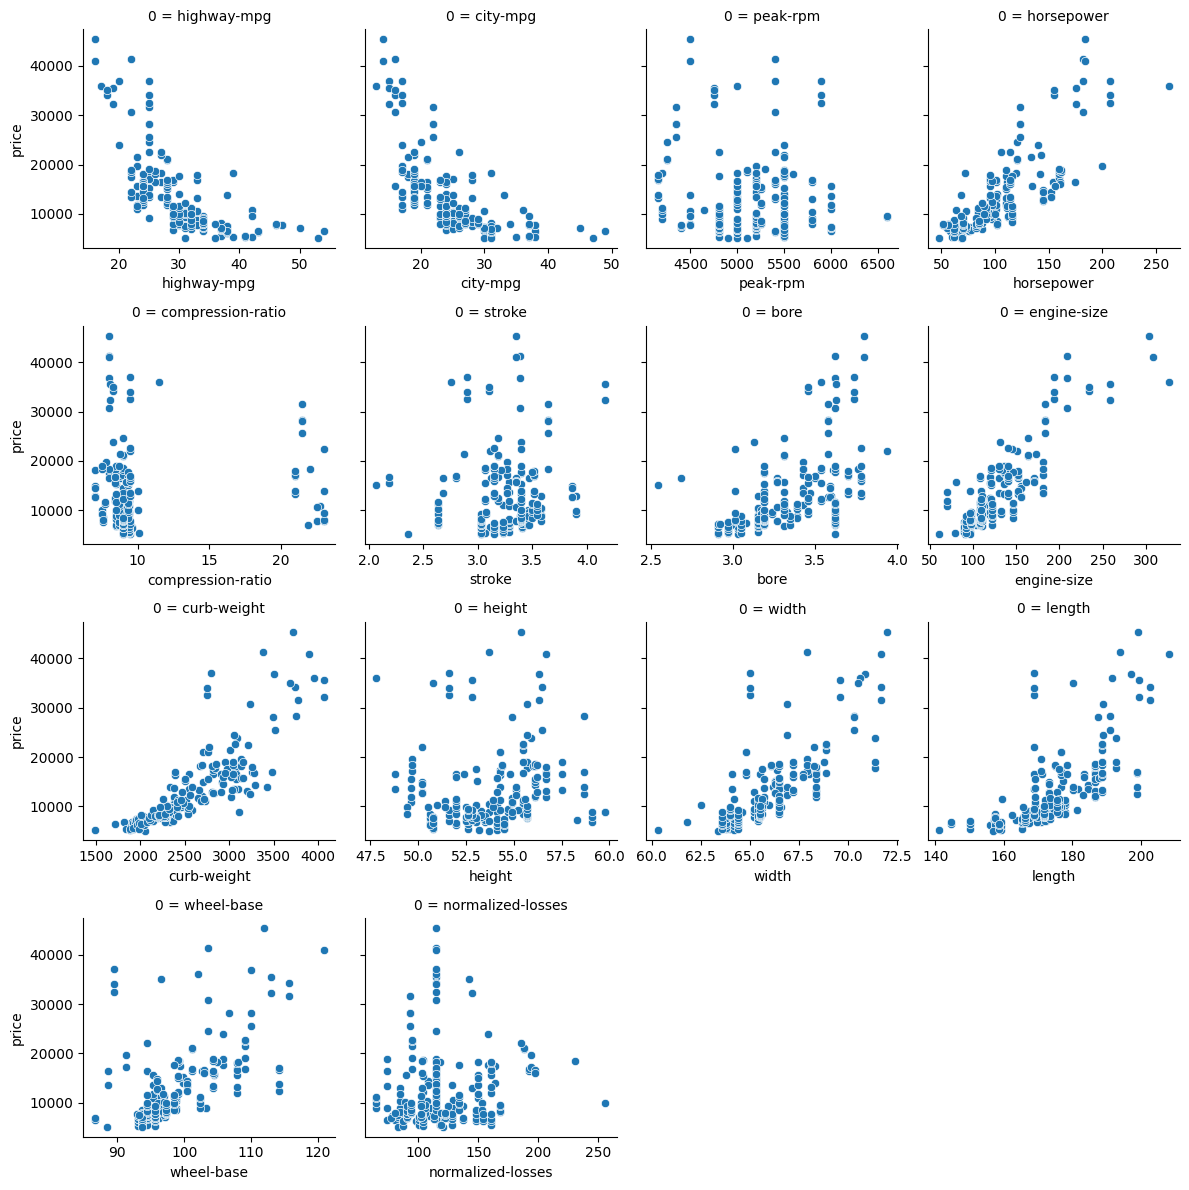

In [7]:
fig = sns.FacetGrid(pd.DataFrame(numerical_cols), col=0, col_wrap=4, sharex=False)

for ax, varx in zip(fig.axes, numerical_cols):
    sns.scatterplot(data=df[numerical_cols + ["price"]], x=varx, y="price", ax=ax)

fig.tight_layout()
fig

##### Разбить выборку на обучающую и тестовую.

In [8]:
df_original = df.copy()

X = df.drop("price", axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (150, 25)
Размер тестовой выборки: (51, 25)


##### Нормализовать числовые данные

In [9]:
scaler = StandardScaler()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train.head()

,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,num-of-cylinders,...,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses,symboling
178,-1.021,-0.852,0.180,1.641,-0.200,0.292,-0.190,mpfi,1.140,6,...,0.711,front,rwd,hatchback,2.000,std,gas,toyota,2.373,3
5,-0.866,-1.019,0.803,0.221,-0.407,0.447,-0.491,mpfi,0.271,5,...,0.175,front,fwd,sedan,2.000,std,gas,audi,-0.161,2
130,0.067,-0.353,0.180,-0.197,-0.356,2.000,0.524,mpfi,0.172,4,...,-0.464,front,fwd,wagon,4.000,std,gas,renault,-0.161,0
120,1.156,0.979,0.803,-0.949,-0.174,-0.081,-1.318,2bbl,-0.872,4,...,-0.878,front,fwd,hatchback,4.000,std,gas,plymouth,1.044,1
76,1.623,1.977,0.803,-0.949,-0.174,-0.081,-1.318,2bbl,-0.822,4,...,-0.878,front,fwd,hatchback,2.000,std,gas,mitsubishi,1.260,2


##### Убрать категориальные признаки

In [10]:
X_train_numeric = X_train.drop(categorical_cols, axis=1)
X_test_numeric = X_test.drop(categorical_cols, axis=1)

display(X_train.shape)
display(X_train_numeric.shape)

(150, 25)

(150, 14)

#### 3. Регрессия МНК:
   - Обучить модель линейной регрессии `LinearRegression`.
   - Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.
   - Вывести `model.coef_` и `model.intercept_`.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

##### Обучить модель линейной регрессии `LinearRegression`.

In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train_numeric, y_train)

y_pred = lr_model.predict(X_test_numeric)

##### Вывести метрики $MSE$, $MAE$ и $R^2$ на тестовом наборе.

In [12]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"Метрики для модели {model_name}:")
    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R^2: {r2:.4f}")

    return [model_name, mse, mae, r2]

In [13]:
lr_metrics = evaluate_model(
    y_test, y_pred, "LinearRegression без категориальных признаков"
)

Метрики для модели LinearRegression без категориальных признаков:
MSE: 21962731.029
MAE: 3160.732
R^2: 0.7965


##### Вывести `model.coef_` и `model.intercept_`.

In [14]:
print("Коэффициенты LinearRegression без категориальных признаков:")
for feature, coef in zip(X_train_numeric.columns, lr_model.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {lr_model.intercept_:.4f}")

Коэффициенты LinearRegression без категориальных признаков:
highway-mpg: 1167.1430
city-mpg: -2433.0012
peak-rpm: 547.3225
horsepower: 1095.3133
compression-ratio: 1037.6606
stroke: -821.6589
bore: -352.5121
engine-size: 4041.0488
curb-weight: -379.1347
height: 169.6366
width: 811.1378
length: -624.9094
wheel-base: 1399.8969
normalized-losses: 176.1177

Свободный член (intercept): 12593.3533


##### Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

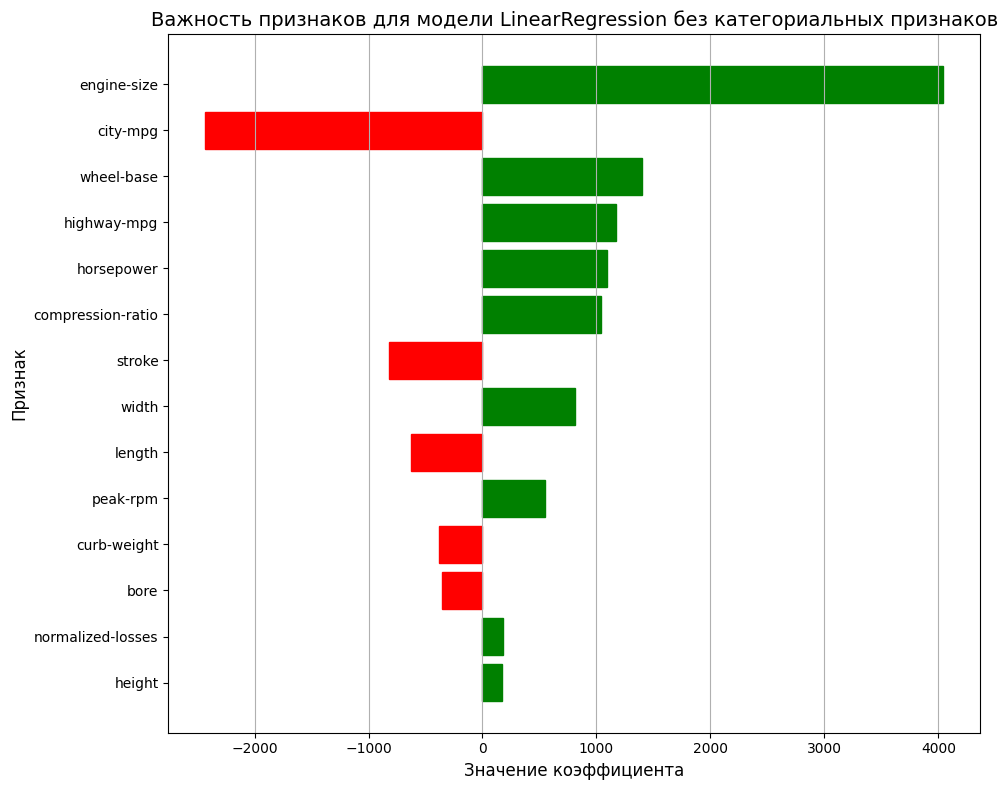

In [15]:
def plot_feature_importance(model, feature_names, model_name):
    coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": model.coef_})

    coef_df["Abs_Coefficient"] = np.abs(coef_df["Coefficient"])
    coef_df = coef_df.sort_values("Abs_Coefficient", ascending=True)

    plt.figure(figsize=(10, 8))
    bars = plt.barh(coef_df["Feature"], coef_df["Coefficient"])

    for i, bar in enumerate(bars):
        if coef_df["Coefficient"].iloc[i] < 0:
            bar.set_color("red")
        else:
            bar.set_color("green")

    plt.title(f"Важность признаков для модели {model_name}", fontsize=14)
    plt.xlabel("Значение коэффициента", fontsize=12)
    plt.ylabel("Признак", fontsize=12)
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.show()


plot_feature_importance(
    lr_model,
    X_train_numeric.columns,
    "LinearRegression без категориальных признаков",
)

#### 4. Для каждого вида регрессии (`Ridge`, `LASSO`, `Elastic Net`):
   - С использованием `GridSearchCV` осуществить подбор параметров регуляризации (`alpha` для `Ridge` и `LASSO`, `alpha` и `l1_ratio` для `Elastic Net`)
   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе для наилучшей модели ($MSE$, $MAE$ и $R^2$).
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

##### С использованием `GridSearchCV` осуществить подбор параметров регуляризации (`alpha` для `Ridge` и `LASSO`, `alpha` и `l1_ratio` для `Elastic Net`)

In [16]:
ridge_params = {"alpha": np.logspace(-3, 1, 20)}

ridge = Ridge(random_state=42)

ridge_grid = GridSearchCV(
    ridge, ridge_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

ridge_grid.fit(X_train_numeric, y_train)

print(f"Лучшее значение alpha для Ridge: {ridge_grid.best_params_['alpha']}")

best_ridge = ridge_grid.best_estimator_

y_pred_ridge = best_ridge.predict(X_test_numeric)

Лучшее значение alpha для Ridge: 10.0


In [17]:
lasso_params = {"alpha": np.logspace(-3, 1, 20)}

lasso = Lasso(random_state=42, max_iter=10000)

lasso_grid = GridSearchCV(
    lasso, lasso_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

lasso_grid.fit(X_train_numeric, y_train)

print(f"Лучшее значение alpha для LASSO: {lasso_grid.best_params_['alpha']}")

best_lasso = lasso_grid.best_estimator_

y_pred_lasso = best_lasso.predict(X_test_numeric)

Лучшее значение alpha для LASSO: 10.0


In [18]:
elastic_params = {"alpha": np.logspace(-3, 1, 20), "l1_ratio": np.linspace(0.1, 0.9, 9)}

elastic = ElasticNet(random_state=42, max_iter=10000)

elastic_grid = GridSearchCV(
    elastic, elastic_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

elastic_grid.fit(X_train_numeric, y_train)

print(f"Лучшие параметры для Elastic Net:")
print(f"alpha: {elastic_grid.best_params_['alpha']}")
print(f"l1_ratio: {elastic_grid.best_params_['l1_ratio']}")

best_elastic = elastic_grid.best_estimator_

y_pred_elastic = best_elastic.predict(X_test_numeric)

Лучшие параметры для Elastic Net:
alpha: 0.20691380811147903
l1_ratio: 0.4


##### Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе для наилучшей модели ($MSE$, $MAE$ и $R^2$).

In [19]:
print("Коэффициенты Ridge без категориальных признаков:")
for feature, coef in zip(X_train_numeric.columns, best_ridge.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_ridge.intercept_:.4f}\n")

ridge_metrics = evaluate_model(
    y_test, y_pred_ridge, "Ridge без категориальных признаков"
)

Коэффициенты Ridge без категориальных признаков:
highway-mpg: -35.7412
city-mpg: -784.3802
peak-rpm: 334.0662
horsepower: 1375.4154
compression-ratio: 674.6151
stroke: -619.0631
bore: -306.4381
engine-size: 3056.4924
curb-weight: 349.7607
height: 36.2117
width: 808.3889
length: -80.9298
wheel-base: 927.0904
normalized-losses: 203.9003

Свободный член (intercept): 12593.3533

Метрики для модели Ridge без категориальных признаков:
MSE: 23849701.077
MAE: 3188.559
R^2: 0.7790


In [20]:
print("Коэффициенты LASSO без категориальных признаков:")
for feature, coef in zip(X_train_numeric.columns, best_lasso.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_lasso.intercept_:.4f}\n")

lasso_metrics = evaluate_model(
    y_test, y_pred_lasso, "LASSO без категориальных признаков"
)

Коэффициенты LASSO без категориальных признаков:
highway-mpg: 748.0082
city-mpg: -1912.7238
peak-rpm: 529.6235
horsepower: 1059.0731
compression-ratio: 943.1783
stroke: -783.1687
bore: -349.3824
engine-size: 3949.5609
curb-weight: -196.0726
height: 113.3974
width: 768.3251
length: -447.8050
wheel-base: 1257.1670
normalized-losses: 167.4683

Свободный член (intercept): 12593.3533

Метрики для модели LASSO без категориальных признаков:
MSE: 22147396.122
MAE: 3147.914
R^2: 0.7948


In [21]:
print("Коэффициенты Elastic Net без категориальных признаков:")
for feature, coef in zip(X_train_numeric.columns, best_elastic.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_elastic.intercept_:.4f}\n")

elastic_metrics = evaluate_model(
    y_test, y_pred_elastic, "Elastic Net без категориальных признаков"
)

Коэффициенты Elastic Net без категориальных признаков:
highway-mpg: -190.7747
city-mpg: -589.4234
peak-rpm: 243.5497
horsepower: 1388.5084
compression-ratio: 571.7063
stroke: -527.0703
bore: -249.7105
engine-size: 2669.3409
curb-weight: 553.9767
height: -11.3399
width: 801.0189
length: 83.7507
wheel-base: 798.3183
normalized-losses: 208.2553

Свободный член (intercept): 12593.3533

Метрики для модели Elastic Net без категориальных признаков:
MSE: 25221222.183
MAE: 3262.533
R^2: 0.7663


##### Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси). 

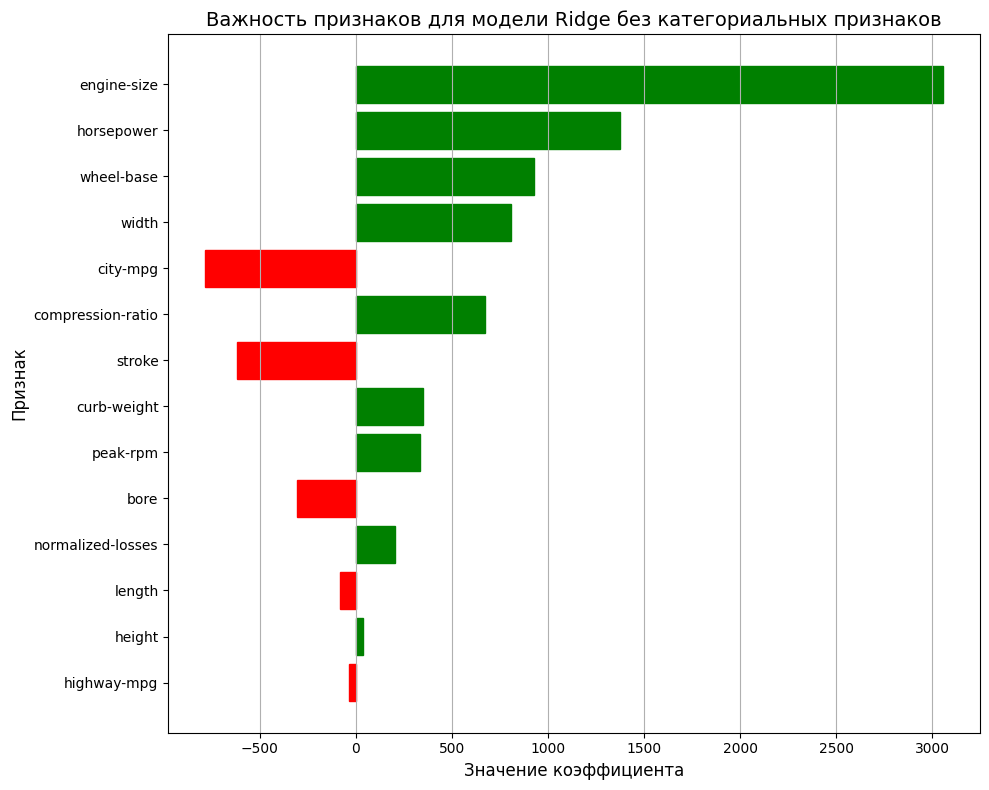

In [22]:
plot_feature_importance(
    best_ridge, X_train_numeric.columns, "Ridge без категориальных признаков"
)

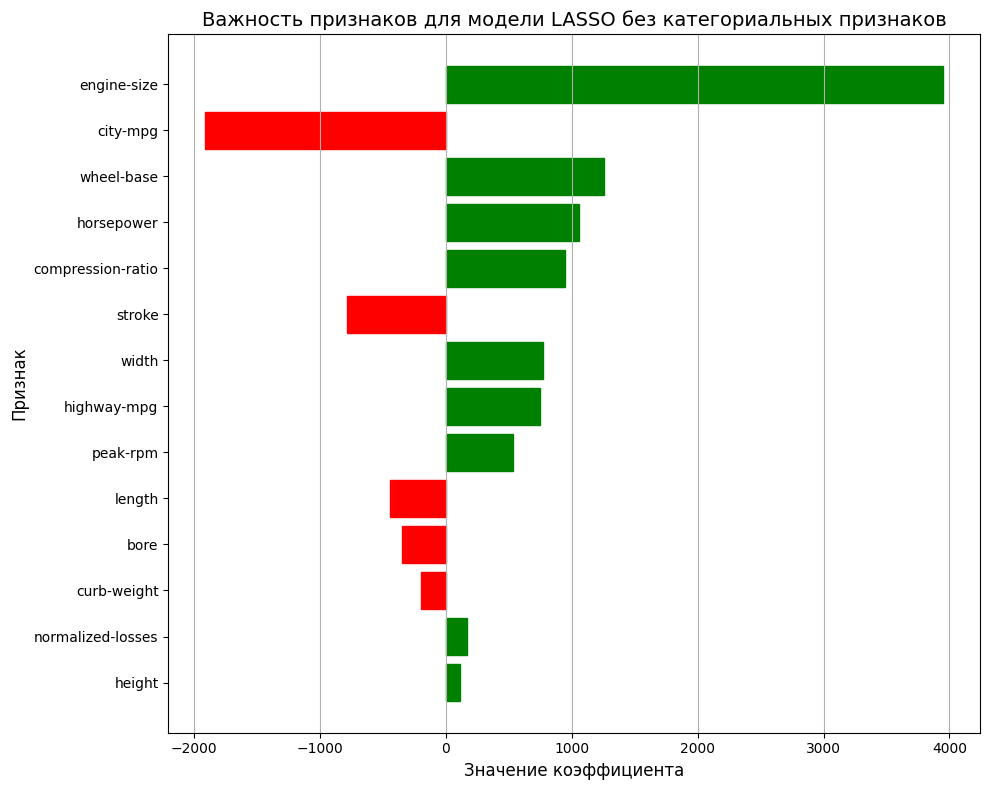

In [23]:
plot_feature_importance(
    best_lasso, X_train_numeric.columns, "LASSO без категориальных признаков"
)

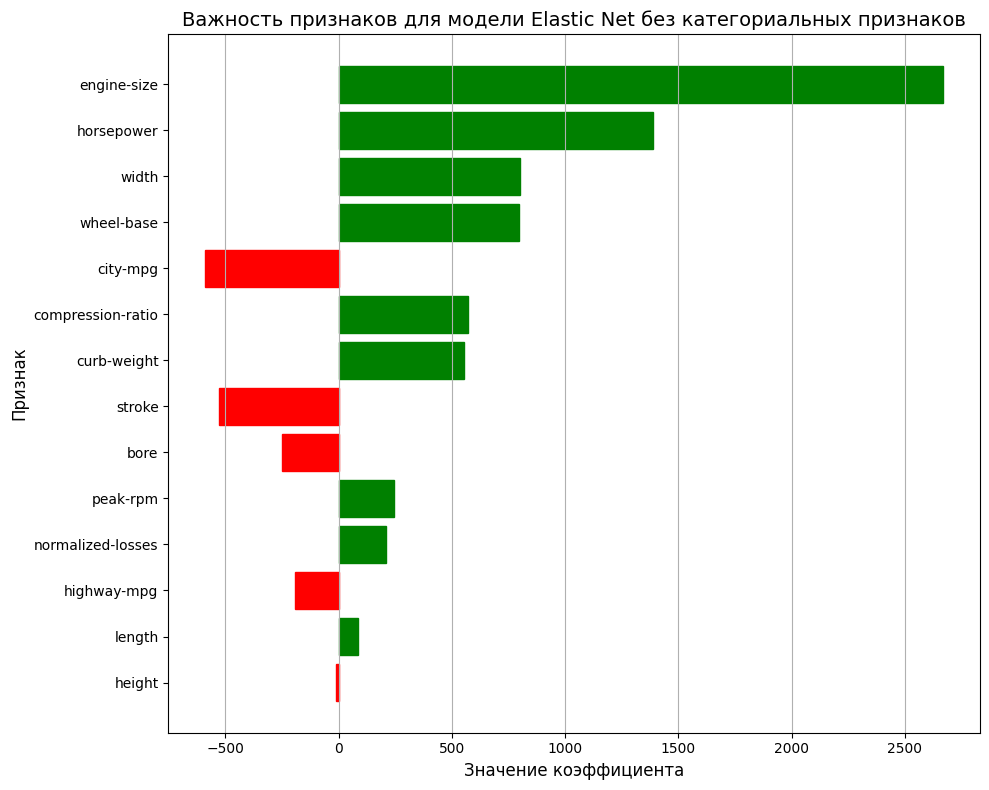

In [24]:
plot_feature_importance(
    best_elastic, X_train_numeric.columns, "Elastic Net без категориальных признаков"
)

#### 5. Датасет и подготовка данных, этап 2:
   - Использовать датафреймы после разбиения на обучающую и тестовую выборки из 1 этапа с категориальными признаками.
   - Закодировать категориальные признаки в обучающей и тестовой выборках.

##### Закодировать категориальные признаки в обучающей и тестовой выборках.

In [25]:
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)[
    X_test_encoded.columns
]

print(f"Количество признаков до кодирования: {X_train.shape[1]}")
print(f"Количество признаков после кодирования: {X_train_encoded.shape[1]}")
assert X_train_encoded.shape[1] == X_test_encoded.shape[1]

Количество признаков до кодирования: 25
Количество признаков после кодирования: 57


#### 6. Регрессии, этап 2:
   - Обучить `LinearRegression`, лучшие модели `Ridge`, `LASSO`, `Elastic Net` на обучающем наборе с категориальными признаками.
   - Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).
   - Сравнить метрики с наличием категориальных признаков и без для каждой из моделей.
   - Выбрать лучшую модель.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
   - Осуществить фильтрацию признаков с использованием `Recursive Feature Elimination`.
   - Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).
   - Вывести значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).

##### Обучить `LinearRegression`, лучшие модели `Ridge`, `LASSO`, `Elastic Net` на обучающем наборе с категориальными признаками.

In [26]:
lr_model_categorical = deepcopy(lr_model)
lr_model_categorical.fit(X_train_encoded, y_train)

y_pred_categorical = lr_model_categorical.predict(X_test_encoded)

In [27]:
best_ridge_categorical = deepcopy(best_ridge)
best_ridge_categorical.fit(X_train_encoded, y_train)

y_pred_ridge_categorical = best_ridge_categorical.predict(X_test_encoded)

In [28]:
best_lasso_categorical = deepcopy(best_lasso)
best_lasso_categorical.fit(X_train_encoded, y_train)

y_pred_lasso_categorical = best_lasso_categorical.predict(X_test_encoded)

In [29]:
best_elastic_categorical = deepcopy(best_elastic)
best_elastic_categorical.fit(X_train_encoded, y_train)

y_pred_elastic_categorical = best_elastic_categorical.predict(X_test_encoded)

##### Вывести значения гиперпараметров, коэффициенты регрессии (`model.coef_` и `model.intercept_`) и значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).

In [30]:
print("Коэффициенты Linear Regression с категориальными признаками:")
for feature, coef in zip(X_train_encoded.columns, lr_model_categorical.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {lr_model_categorical.intercept_:.4f}\n")

lr_metrics_categorical = evaluate_model(
    y_test, y_pred_categorical, "Linear Regression с категориальными признаками"
)

Коэффициенты Linear Regression с категориальными признаками:
highway-mpg: 1105.2008
city-mpg: -1110.9575
peak-rpm: 380.0320
horsepower: 968.4201
compression-ratio: 1262.3313
stroke: -467.8317
bore: 29.5362
engine-size: 742.3194
curb-weight: 2617.6033
height: -92.3488
width: 548.0233
length: -984.3919
wheel-base: 889.3692
normalized-losses: 153.6896
fuel-system_2bbl: 1234.7026
fuel-system_idi: -21504783858457552.0000
fuel-system_mpfi: 1917.0269
fuel-system_spdi: 836.7264
num-of-cylinders_4: -6230.5139
num-of-cylinders_5: -4074.9934
num-of-cylinders_6: -2387.7896
num-of-cylinders_8: 16095.3763
engine-type_l: 31566733624181016.0000
engine-type_ohc: 3078.2155
engine-type_ohcf: 12659575212557904.0000
engine-type_ohcv: -3547.9887
engine-type_rotor: -2052.5958
engine-location_rear: 532073416549571.2500
drive-wheels_fwd: -97.0145
drive-wheels_rwd: 1307.3887
body-style_hardtop: -3458.8002
body-style_hatchback: -3499.1200
body-style_sedan: -3340.8275
body-style_wagon: -4258.0000
num-of-doors_4.0

In [31]:
print("Коэффициенты Ridge с категориальными признаками:")
for feature, coef in zip(X_train_encoded.columns, best_ridge_categorical.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_ridge_categorical.intercept_:.4f}\n")

ridge_metrics_categorical = evaluate_model(
    y_test, y_pred_ridge_categorical, "Ridge с категориальными признаками"
)

Коэффициенты Ridge с категориальными признаками:
highway-mpg: 106.0608
city-mpg: -354.7252
peak-rpm: 158.0899
horsepower: 1144.7366
compression-ratio: 339.4676
stroke: -611.3755
bore: -182.4849
engine-size: 2639.9961
curb-weight: 698.4175
height: 90.1962
width: 655.4068
length: -45.3830
wheel-base: 766.9362
normalized-losses: 31.9797
fuel-system_2bbl: -188.2023
fuel-system_idi: 100.1864
fuel-system_mpfi: 294.3968
fuel-system_spdi: -263.8456
num-of-cylinders_4: -1652.8927
num-of-cylinders_5: 210.1304
num-of-cylinders_6: -273.6960
num-of-cylinders_8: 1177.3172
engine-type_l: -357.5404
engine-type_ohc: 774.6496
engine-type_ohcf: 169.8293
engine-type_ohcv: -725.9480
engine-type_rotor: 332.8749
engine-location_rear: 741.3840
drive-wheels_fwd: -663.1515
drive-wheels_rwd: 711.3467
body-style_hardtop: 705.3470
body-style_hatchback: -664.6742
body-style_sedan: 59.6609
body-style_wagon: -927.2503
num-of-doors_4.0: 11.7006
aspiration_turbo: 195.1723
fuel-type_gas: -100.1864
make_chevrolet: 386.96

In [32]:
print("Коэффициенты LASSO с категориальными признаками:")
for feature, coef in zip(X_train_encoded.columns, best_lasso_categorical.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_lasso_categorical.intercept_:.4f}\n")

lasso_metrics_categorical = evaluate_model(
    y_test, y_pred_lasso_categorical, "LASSO с категориальными признаками"
)

Коэффициенты LASSO с категориальными признаками:
highway-mpg: 450.4522
city-mpg: -489.3309
peak-rpm: 25.6726
horsepower: 1150.8038
compression-ratio: 508.6072
stroke: -735.4765
bore: -69.7495
engine-size: 1629.2469
curb-weight: 2114.7888
height: -19.3755
width: 507.8611
length: -665.3498
wheel-base: 333.5701
normalized-losses: 63.0530
fuel-system_2bbl: 38.8698
fuel-system_idi: -0.0000
fuel-system_mpfi: 978.3310
fuel-system_spdi: -41.4068
num-of-cylinders_4: -3486.1157
num-of-cylinders_5: -0.0000
num-of-cylinders_6: -352.6806
num-of-cylinders_8: 14377.5236
engine-type_l: -0.0000
engine-type_ohc: 1680.1246
engine-type_ohcf: -0.0000
engine-type_ohcv: -4378.6819
engine-type_rotor: 0.0000
engine-location_rear: 7158.9659
drive-wheels_fwd: -0.0000
drive-wheels_rwd: 1313.4464
body-style_hardtop: -0.0000
body-style_hatchback: -1022.3617
body-style_sedan: -573.4538
body-style_wagon: -1545.8712
num-of-doors_4.0: 291.0311
aspiration_turbo: 668.8186
fuel-type_gas: 0.0000
make_chevrolet: 0.0000
make

In [33]:
print("Коэффициенты Elastic Net с категориальными признаками:")
for feature, coef in zip(X_train_encoded.columns, best_elastic_categorical.coef_):
    print(f"{feature}: {coef:.4f}")

print(f"\nСвободный член (intercept): {best_elastic_categorical.intercept_:.4f}\n")

elastic_metrics_caregorical = evaluate_model(
    y_test, y_pred_elastic, "Elastic Net с категориальными признаками"
)

Коэффициенты Elastic Net с категориальными признаками:
highway-mpg: -72.2331
city-mpg: -342.5594
peak-rpm: 106.6798
horsepower: 1178.0806
compression-ratio: 345.5258
stroke: -515.8188
bore: -145.1338
engine-size: 2362.6619
curb-weight: 682.0966
height: 49.1090
width: 706.4635
length: 92.3885
wheel-base: 690.0648
normalized-losses: 47.7871
fuel-system_2bbl: -197.4464
fuel-system_idi: 88.2854
fuel-system_mpfi: 239.7169
fuel-system_spdi: -201.0764
num-of-cylinders_4: -1268.3147
num-of-cylinders_5: 215.8926
num-of-cylinders_6: -88.2414
num-of-cylinders_8: 780.6016
engine-type_l: -293.0425
engine-type_ohc: 536.0903
engine-type_ohcf: 80.1394
engine-type_ohcv: -356.9344
engine-type_rotor: 178.4365
engine-location_rear: 478.9199
drive-wheels_fwd: -559.7067
drive-wheels_rwd: 625.6229
body-style_hardtop: 534.6735
body-style_hatchback: -505.5276
body-style_sedan: 208.7823
body-style_wagon: -710.9200
num-of-doors_4.0: -85.4581
aspiration_turbo: 38.5159
fuel-type_gas: -88.2856
make_chevrolet: 243.1

##### Сравнить метрики с наличием категориальных признаков и без для каждой из моделей.

In [34]:
metrics_df = pd.DataFrame(
    [
        lr_metrics,
        ridge_metrics,
        lasso_metrics,
        elastic_metrics,
        lr_metrics_categorical,
        ridge_metrics_categorical,
        lasso_metrics_categorical,
        elastic_metrics_caregorical,
    ],
    columns=["model", "mse", "mae", "r2"],
)

metrics_df

,model,mse,mae,r2
0,LinearRegression без категориальных признаков,21962731.029,3160.732,0.796
1,Ridge без категориальных признаков,23849701.077,3188.559,0.779
2,LASSO без категориальных признаков,22147396.122,3147.914,0.795
3,Elastic Net без категориальных признаков,25221222.183,3262.533,0.766
4,Linear Regression с категориальными признаками,42488959548107263034661791596544.000,1496570899560101.250,-393732491924939288346624.000
5,Ridge с категориальными признаками,16300519.910,2659.607,0.849
6,LASSO с категориальными признаками,11066650.914,2272.628,0.897
7,Elastic Net с категориальными признаками,25221222.183,3262.533,0.766


##### Выбрать лучшую модель.

In [35]:
best_lr_model = deepcopy(lr_model)
best_ridge_model = deepcopy(best_ridge_categorical)
best_lasso_model = deepcopy(best_lasso_categorical)
best_elastic_model = deepcopy(best_elastic_categorical)
best_model = deepcopy(best_lr_model)

##### Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

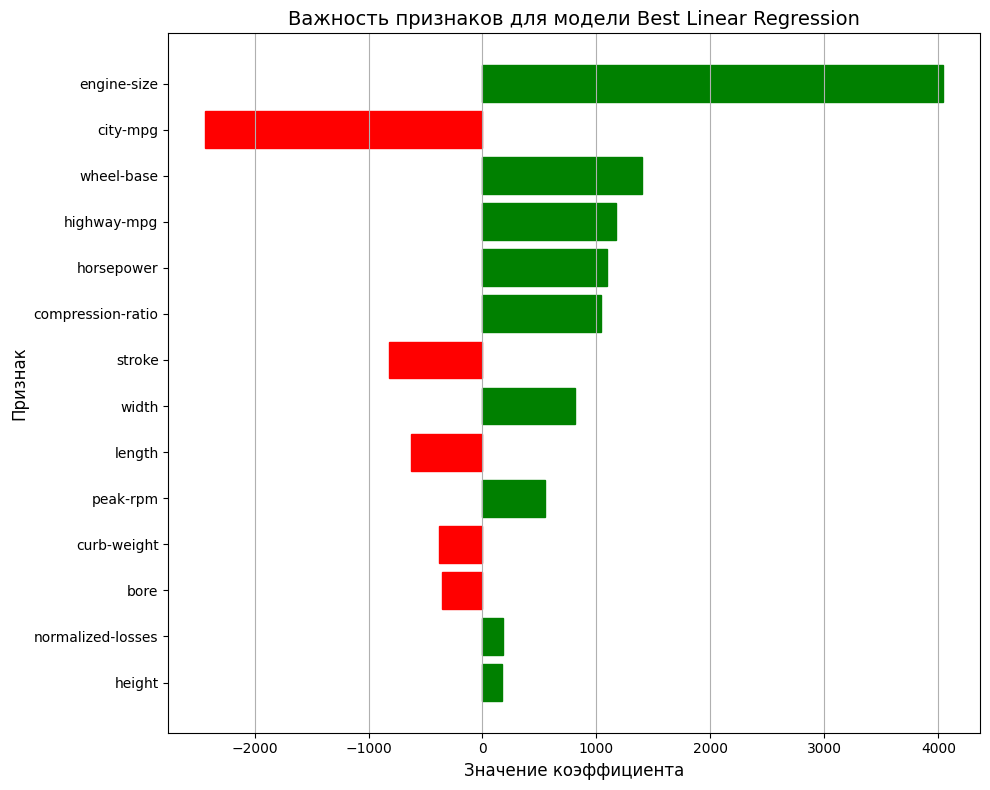

In [36]:
plot_feature_importance(
    best_lr_model, X_train_numeric.columns, "Best Linear Regression"
)

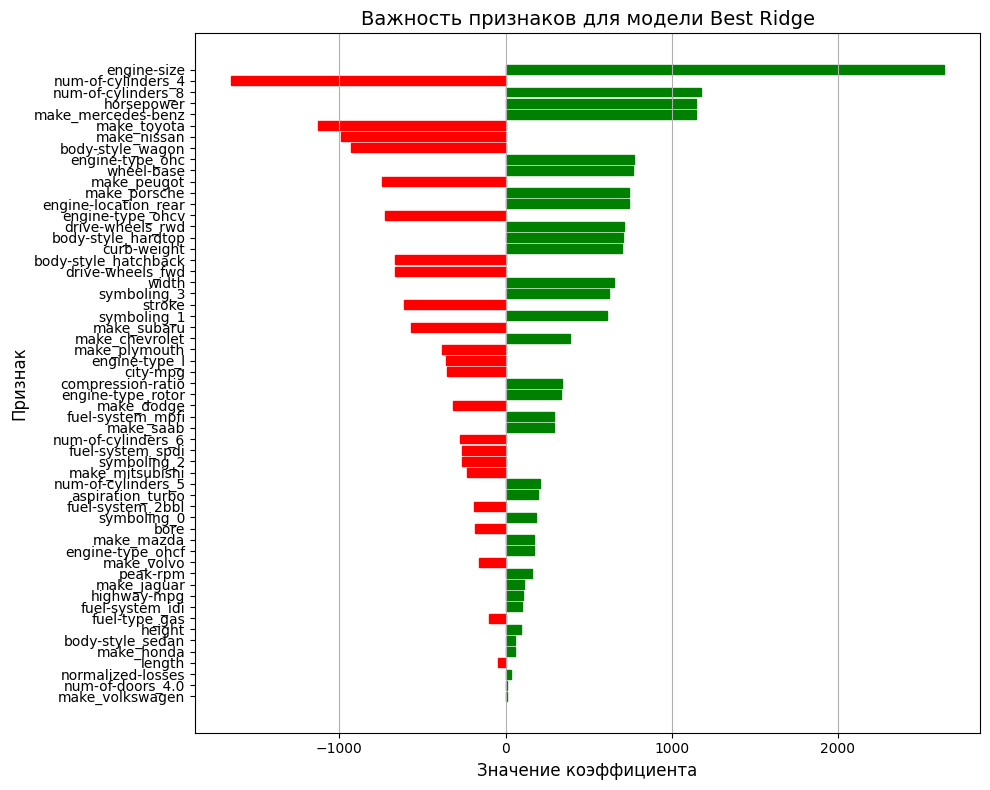

In [37]:
plot_feature_importance(best_ridge_model, X_train_encoded.columns, "Best Ridge")

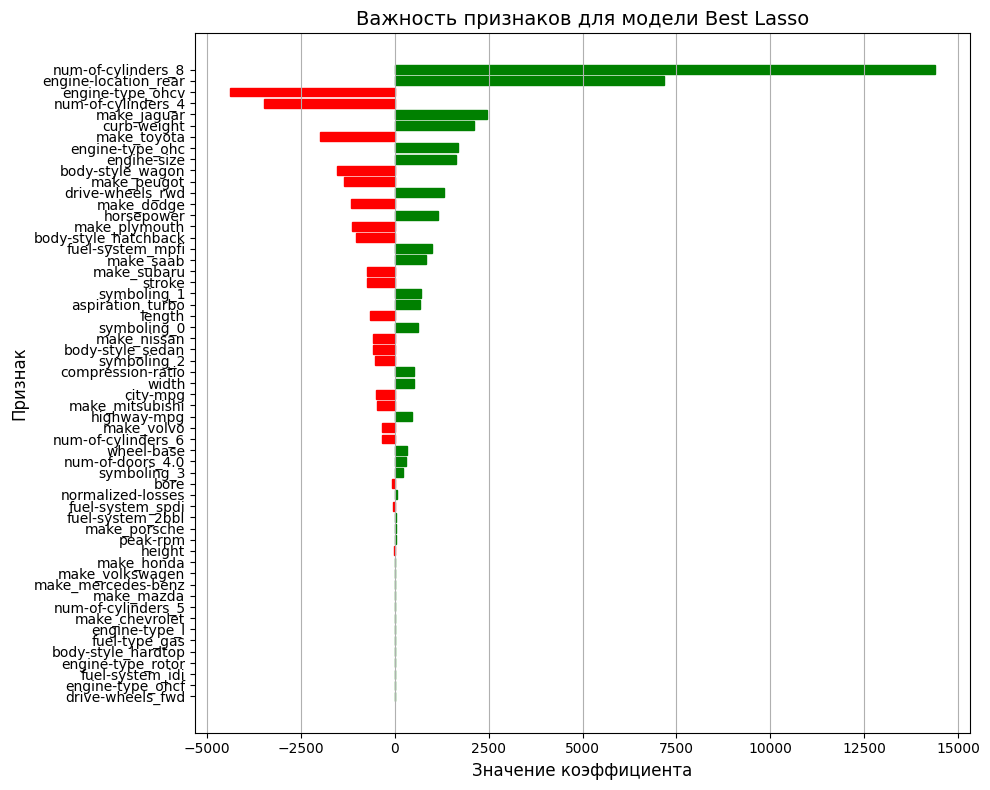

In [38]:
plot_feature_importance(best_lasso_model, X_train_encoded.columns, "Best Lasso")

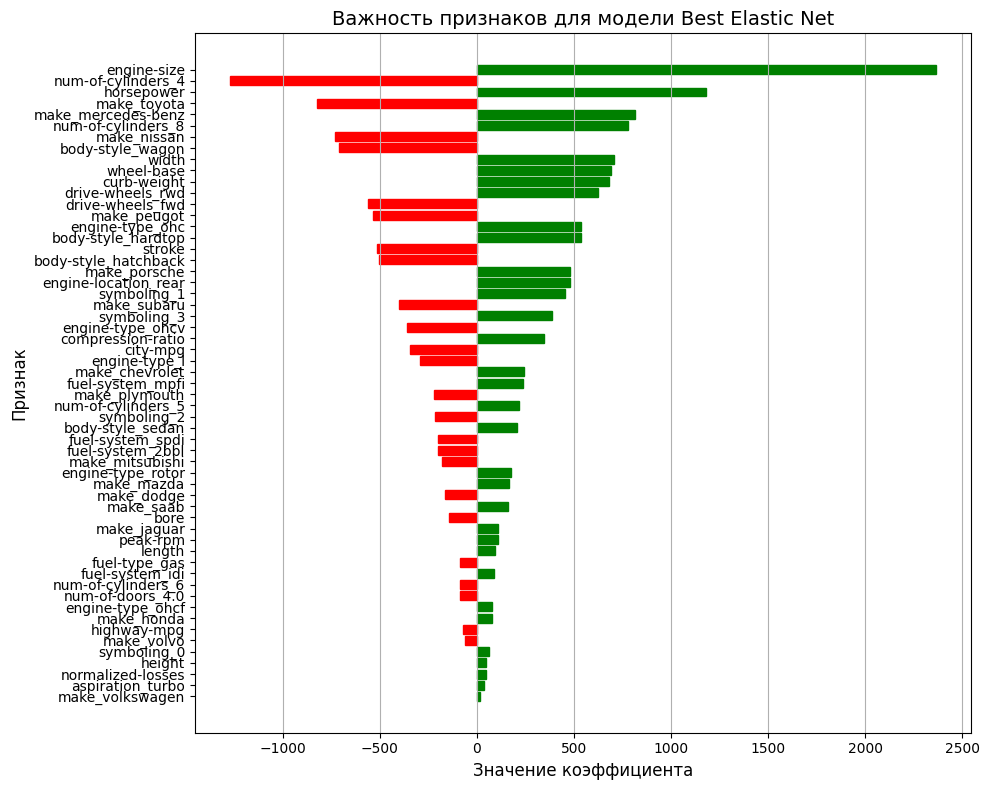

In [39]:
plot_feature_importance(best_elastic_model, X_train_encoded.columns, "Best Elastic Net")

##### Осуществить фильтрацию признаков с использованием `Recursive Feature Elimination`.

In [40]:
rfe = RFE(estimator=best_lr_model, n_features_to_select=X_train_numeric.shape[1] // 2)
model = best_lr_model

lr_rfe_pipeline = Pipeline(steps=[("rfe", rfe), ("model", model)])
lr_rfe_pipeline.fit(X_train_numeric, y_train)

y_pred_lr_rfe = lr_rfe_pipeline.predict(X_test_numeric)

lr_selected_features = lr_rfe_pipeline.named_steps["rfe"].get_feature_names_out()

print(f"Количество отобранных признаков: {len(lr_selected_features)}")
print("Отобранные признаки:")
print(*lr_selected_features, sep="\n")

Количество отобранных признаков: 7
Отобранные признаки:
highway-mpg
city-mpg
horsepower
compression-ratio
engine-size
width
wheel-base


In [41]:
rfe = RFE(
    estimator=best_ridge_model, n_features_to_select=X_train_encoded.shape[1] // 2
)
model = best_ridge_model

ridge_rfe_pipeline = Pipeline(steps=[("rfe", rfe), ("model", model)])
ridge_rfe_pipeline.fit(X_train_encoded, y_train)

y_pred_ridge_rfe = ridge_rfe_pipeline.predict(X_test_encoded)

ridge_selected_features = ridge_rfe_pipeline.named_steps["rfe"].get_feature_names_out()

print(f"Количество отобранных признаков: {len(ridge_selected_features)}")
print("Отобранные признаки:")
print(*ridge_selected_features, sep="\n")

Количество отобранных признаков: 28
Отобранные признаки:
city-mpg
horsepower
compression-ratio
stroke
engine-size
curb-weight
width
wheel-base
fuel-system_2bbl
fuel-system_spdi
num-of-cylinders_4
num-of-cylinders_8
engine-type_ohc
engine-type_ohcv
engine-location_rear
drive-wheels_fwd
drive-wheels_rwd
body-style_hardtop
body-style_hatchback
body-style_wagon
make_mercedes-benz
make_nissan
make_peugot
make_porsche
make_subaru
make_toyota
symboling_1
symboling_3


In [42]:
rfe = RFE(
    estimator=best_lasso_model, n_features_to_select=X_train_encoded.shape[1] // 2
)
model = best_lasso_model

lasso_rfe_pipeline = Pipeline(steps=[("rfe", rfe), ("model", model)])
lasso_rfe_pipeline.fit(X_train_encoded, y_train)

y_pred_lasso_rfe = lasso_rfe_pipeline.predict(X_test_encoded)

lasso_selected_features = lasso_rfe_pipeline.named_steps["rfe"].get_feature_names_out()

print(f"Количество отобранных признаков: {len(lasso_selected_features)}")
print("Отобранные признаки:")
print(*lasso_selected_features, sep="\n")

Количество отобранных признаков: 28
Отобранные признаки:
horsepower
compression-ratio
stroke
engine-size
curb-weight
width
length
fuel-system_mpfi
num-of-cylinders_4
num-of-cylinders_8
engine-type_ohc
engine-type_ohcv
engine-location_rear
drive-wheels_rwd
body-style_hatchback
body-style_wagon
aspiration_turbo
make_dodge
make_jaguar
make_peugot
make_plymouth
make_saab
make_subaru
make_toyota
make_volvo
symboling_0
symboling_1
symboling_2


In [43]:
rfe = RFE(
    estimator=best_elastic_model, n_features_to_select=X_train_encoded.shape[1] // 2
)
model = best_elastic_model

elastic_rfe_pipeline = Pipeline(steps=[("rfe", rfe), ("model", model)])
elastic_rfe_pipeline.fit(X_train_encoded, y_train)

y_pred_elastic_rfe = elastic_rfe_pipeline.predict(X_test_encoded)

elastic_selected_features = elastic_rfe_pipeline.named_steps[
    "rfe"
].get_feature_names_out()

print(f"Количество отобранных признаков: {len(elastic_selected_features)}")
print("Отобранные признаки:")
print(*elastic_selected_features, sep="\n")

Количество отобранных признаков: 28
Отобранные признаки:
city-mpg
horsepower
compression-ratio
stroke
engine-size
curb-weight
width
wheel-base
fuel-system_2bbl
num-of-cylinders_4
num-of-cylinders_8
engine-type_l
engine-type_ohc
engine-type_ohcv
engine-location_rear
drive-wheels_fwd
drive-wheels_rwd
body-style_hardtop
body-style_hatchback
body-style_wagon
make_mercedes-benz
make_nissan
make_peugot
make_porsche
make_subaru
make_toyota
symboling_1
symboling_3


##### Построить график (`barh`) с важностью коэфициентов при соответствующих признаках (сверху вниз расположены коэффициенты по убыванию, а названия соответствующих признаков подписаны по вертикальной оси).

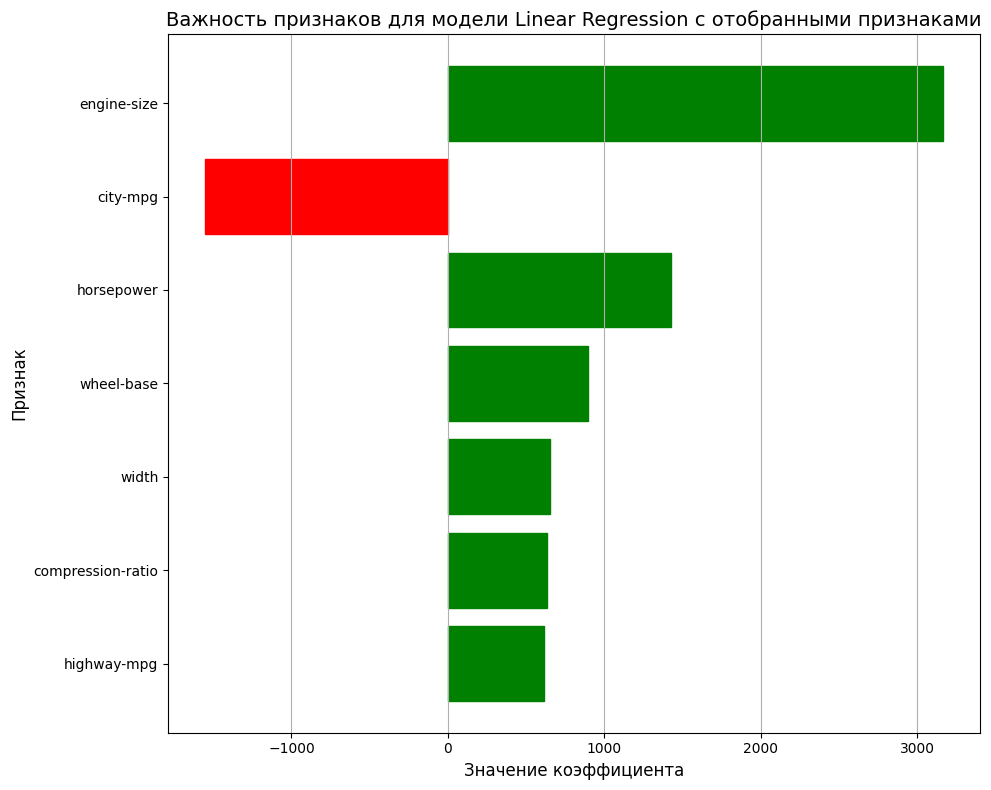

In [44]:
plot_feature_importance(
    lr_rfe_pipeline.named_steps["model"],
    lr_selected_features,
    "Linear Regression с отобранными признаками",
)

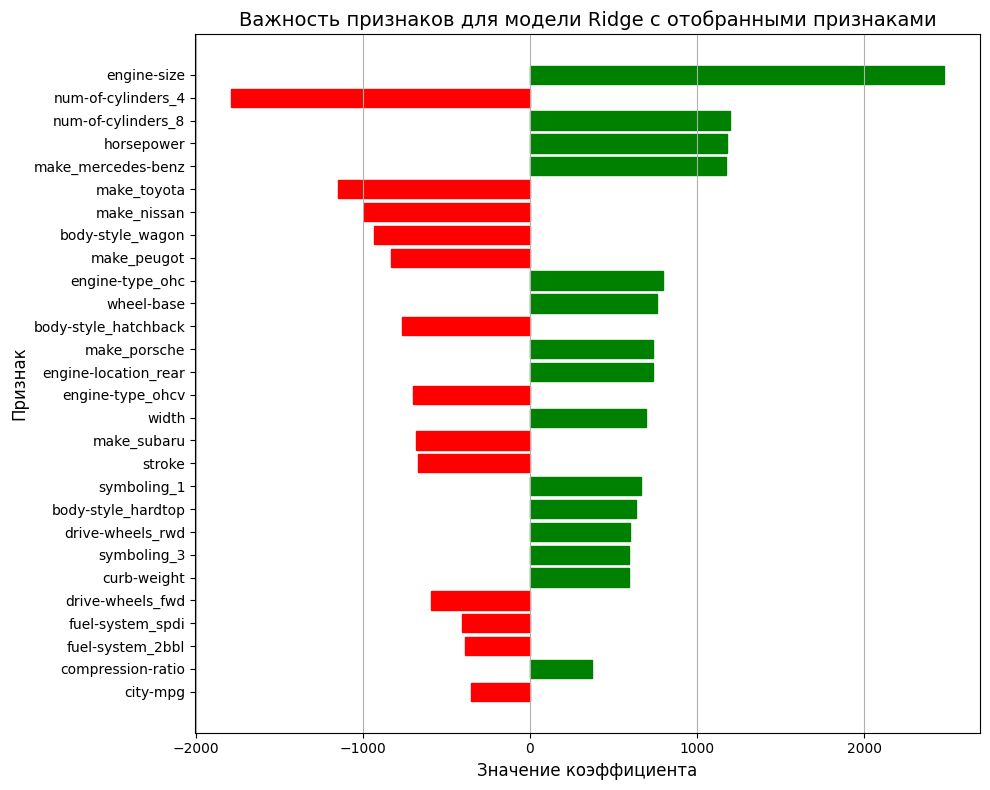

In [45]:
plot_feature_importance(
    ridge_rfe_pipeline.named_steps["model"],
    ridge_selected_features,
    "Ridge с отобранными признаками",
)

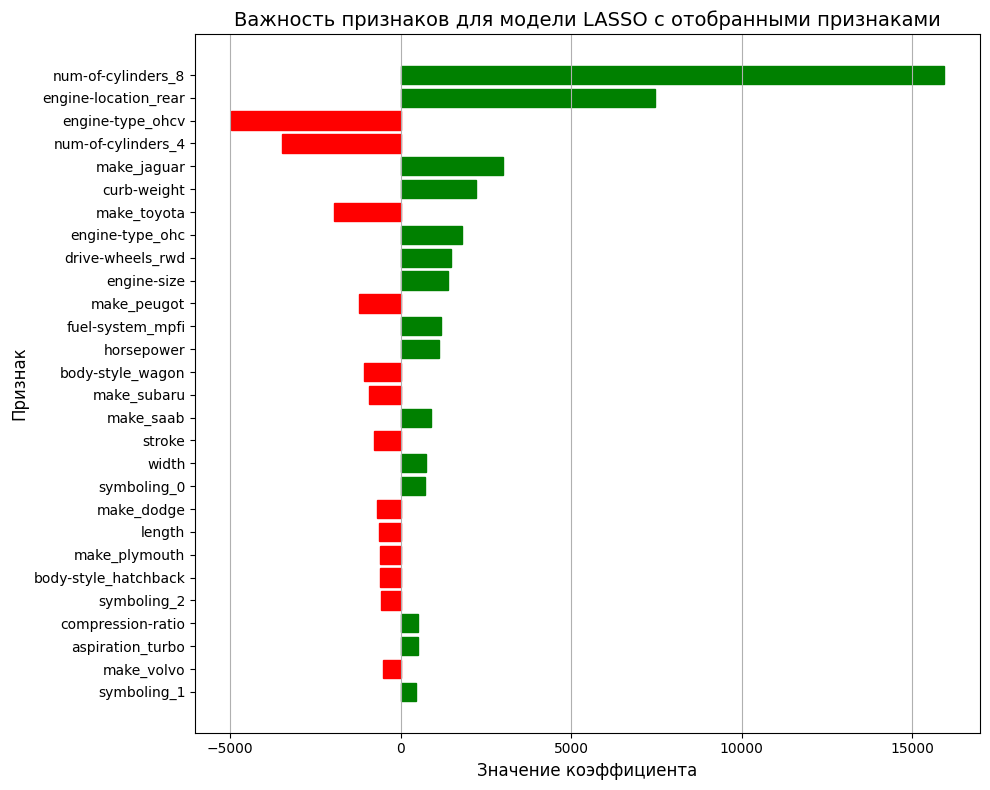

In [46]:
plot_feature_importance(
    lasso_rfe_pipeline.named_steps["model"],
    lasso_selected_features,
    "LASSO с отобранными признаками",
)

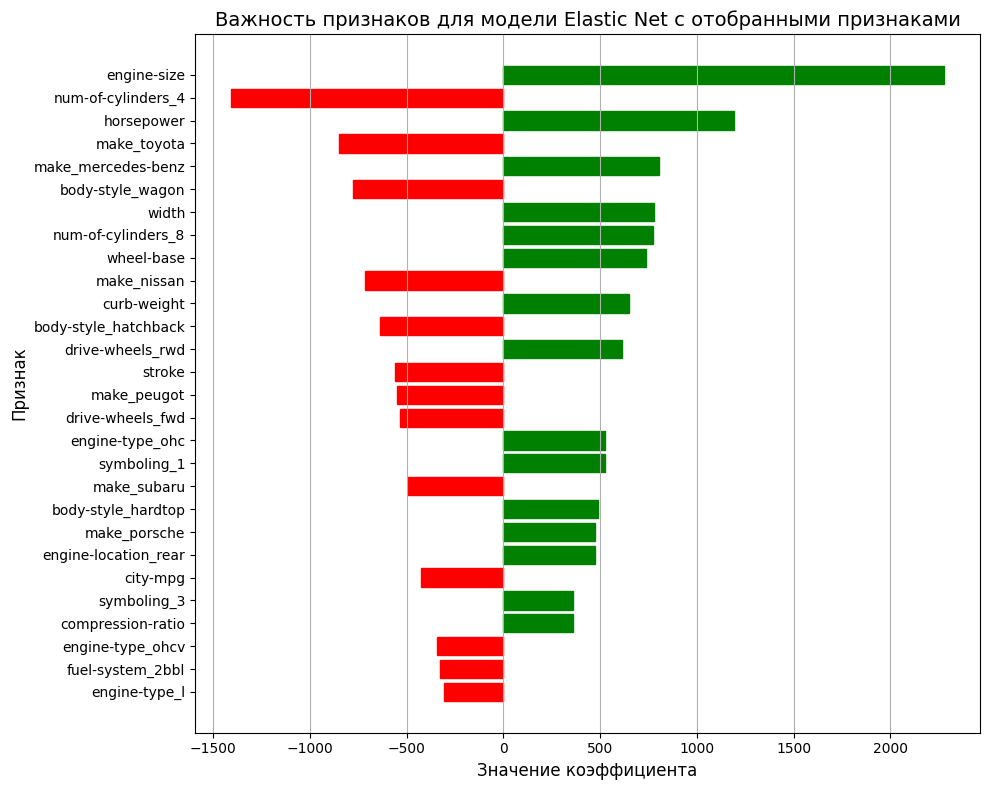

In [47]:
plot_feature_importance(
    elastic_rfe_pipeline.named_steps["model"],
    elastic_selected_features,
    "Elastic Net с отобранными признаками",
)

##### Вывести значения метрик на тестовом наборе ($MSE$, $MAE$ и $R^2$).

In [48]:
lr_rfe_metrics = evaluate_model(
    y_test, y_pred_lr_rfe, "Linear Regression с отобранными признаками"
)
ridge_rfe_metrics = evaluate_model(
    y_test, y_pred_ridge_rfe, "Ridge с отобранными признаками"
)
lasso_rfe_metrics = evaluate_model(
    y_test, y_pred_lasso_rfe, "LASSO с отобранными признаками"
)
elastic_rfe_metrics = evaluate_model(
    y_test, y_pred_elastic_rfe, "Elastic Net с отобранными признаками"
)

Метрики для модели Linear Regression с отобранными признаками:
MSE: 24473508.044
MAE: 3367.911
R^2: 0.7732
Метрики для модели Ridge с отобранными признаками:
MSE: 16695185.634
MAE: 2702.075
R^2: 0.8453
Метрики для модели LASSO с отобранными признаками:
MSE: 11040549.005
MAE: 2309.868
R^2: 0.8977
Метрики для модели Elastic Net с отобранными признаками:
MSE: 19310204.929
MAE: 2880.294
R^2: 0.8211


In [49]:
rfe_metrics_df = pd.DataFrame(
    [lr_rfe_metrics, ridge_rfe_metrics, lasso_rfe_metrics, elastic_rfe_metrics],
    columns=["model", "mse", "mae", "r2"],
)

metrics_df = pd.concat([metrics_df, rfe_metrics_df], ignore_index=True)

metrics_df

,model,mse,mae,r2
0,LinearRegression без категориальных признаков,21962731.029,3160.732,0.796
1,Ridge без категориальных признаков,23849701.077,3188.559,0.779
2,LASSO без категориальных признаков,22147396.122,3147.914,0.795
3,Elastic Net без категориальных признаков,25221222.183,3262.533,0.766
4,Linear Regression с категориальными признаками,42488959548107263034661791596544.000,1496570899560101.250,-393732491924939288346624.000
5,Ridge с категориальными признаками,16300519.910,2659.607,0.849
6,LASSO с категориальными признаками,11066650.914,2272.628,0.897
7,Elastic Net с категориальными признаками,25221222.183,3262.533,0.766
8,Linear Regression с отобранными признаками,24473508.044,3367.911,0.773
9,Ridge с отобранными признаками,16695185.634,2702.075,0.845


#### 7. Сделать вывод:
   - Лучший регрессор, обученный на данных без категориальных признаков (значения метрик на тестовом наборе).
   - Лучший регрессор, обученный на данных с категориальными признаками (значения метрик на тестовом наборе).
   - Вывод о результатах использования `Recursive Feature Elimination` (лучше или хуже - значения метрик).

##### Лучший регрессор, обученный на данных без категориальных признаков (значения метрик на тестовом наборе).

In [50]:
metrics_df[
    metrics_df["model"].str.endswith("без категориальных признаков")
].sort_values(by="mse")

,model,mse,mae,r2
0,LinearRegression без категориальных признаков,21962731.029,3160.732,0.796
2,LASSO без категориальных признаков,22147396.122,3147.914,0.795
1,Ridge без категориальных признаков,23849701.077,3188.559,0.779
3,Elastic Net без категориальных признаков,25221222.183,3262.533,0.766


**Лучший регрессор без категориальных признаков - LinearRegression**

##### Лучший регрессор, обученный на данных с категориальными признаками (значения метрик на тестовом наборе).

In [51]:
metrics_df[
    metrics_df["model"].str.endswith("с категориальными признаками")
].sort_values(by="mse")

,model,mse,mae,r2
6,LASSO с категориальными признаками,11066650.914,2272.628,0.897
5,Ridge с категориальными признаками,16300519.910,2659.607,0.849
7,Elastic Net с категориальными признаками,25221222.183,3262.533,0.766
4,Linear Regression с категориальными признаками,42488959548107263034661791596544.000,1496570899560101.250,-393732491924939288346624.000


**Лучший регрессор с категориальными признаками - LASSO**

##### Вывод о результатах использования `Recursive Feature Elimination` (лучше или хуже - значения метрик).

In [52]:
metrics_df[metrics_df["model"].str.endswith("с отобранными признаками")].sort_values(
    by="mse"
)

,model,mse,mae,r2
10,LASSO с отобранными признаками,11040549.005,2309.868,0.898
9,Ridge с отобранными признаками,16695185.634,2702.075,0.845
11,Elastic Net с отобранными признаками,19310204.929,2880.294,0.821
8,Linear Regression с отобранными признаками,24473508.044,3367.911,0.773


**Отбор признаков позволил улучшить метрики для моделей Lasso, Elastic Net с категориальными признаками** \
**Для Linear Regression без категориальных признаков и Ridge с категориальными признаками метрики после RFE ухудшились**